In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.feature_extraction.text import TfidfVectorizer
from pathlib import Path

test_set = {"Analyst","Senior Management","Skilled Trade","Sports/Fitness"}
# test_set = ["Accounting/Finance","Business Development/Consulting","Legal","Marketing/Advertising/PR","Medical/Healthcare",
#            "Science/Research","Travel/Transportation","Manufacturing/Production/Construction","Beauty/Wellness"]
#test_set = ["Software Development/IT"]
data_set = {}

def do_svd(category, filenames):
    # for now just do analysis for a few categories
    if category not in test_set: 
        return
    
    # concatenate the csv files into one dataframe df
    dfs = []
    for filename in filenames:
        df = pd.read_csv(filename)
        dfs.append(df)
    if len(dfs) < 1: return
    df = pd.concat(dfs)
    
    # saving df and svd result into data_set dictionary
    (u, s, vt) = svd(df)
    '''
    plt.title("svd result (" + category + ")")
    plt.xlim([0,100])
    plt.plot(range(1,len(s)+1),s)
    plt.show()
    '''
    data_set[category] = (df, u, s, vt)
    
def svd(df):
    vectorizer = TfidfVectorizer(stop_words='english', min_df=4,max_df=0.8)
    dtm = vectorizer.fit_transform(df['job_description'].tolist())
    dtm_dense = dtm.todense()
    centered_dtm = dtm_dense - np.mean(dtm_dense, axis=0)
    u, s, vt = np.linalg.svd(centered_dtm)
    return (u, s, pd.DataFrame(vt,columns = vectorizer.get_feature_names()))

with open('top_cities.csv','r') as src:
    for line in src:
        line = line.split(',')
        # Skips header.
        if line[0] == "job_category": continue
        # Job category
        job_category = line[0].split('/')
        if len(job_category) > 1:
            job_category = '_'.join(job_category)
        else:
            job_category = job_category[0].replace(' ','_')
        filenames = []
        # Top 10 cities
        for i in range(1,11):
            city = line[i*2 -1].replace(' ','').replace('"','')
            filename = "dataset/" + job_category + city + '.csv'
            if Path(filename).is_file():
                filenames.append(filename)
        do_svd(line[0], filenames)
print('Done')

Done


In [2]:
# The number of principal components determined from svd results
pc_num_dictionary = {"Accounting/Finance":15, \
                     "Administrative":20, \
                     "Analyst":5, \
                     "Architecture/Drafting":15, \
                     "Art/Design/Entertainment":10, \
                     "Banking/Loan/Insurance":10, \
                     "Beauty/Wellness":13, \
                     "Business Development/Consulting":7, \
                     "Education":5, \
                     "Facilities/General Labor":5, \
                     "Hospitality":10, \
                     "Human Resources":7, \
                     "Installation/Maintenance/Repair":5, \
                     "Legal":5, \
                     "Manufacturing/Production/Construction":10, \
                     "Marketing/Advertising/PR":10, \
                     "Medical/Healthcare":10, \
                     "Product/Project Management":10, \
                     "Real Estate":20, \
                     "Restaurant/Food Services":15, \
                     "Retail":10, \
                     "Science/Research":15, \
                     "Security/Law Enforcement":10, \
                     "Senior Management":7, \
                     "Skilled Trade":7, \
                     "Software Development/IT":10, \
                     "Sports/Fitness":7, \
                     "Travel/Transportation":7, \
                     "Writing/Editing/Publishing":7 }

# The number of clusters determined from error plots
k_value_dictionary = {"Accounting/Finance":18, \
                     "Administrative":28, \
                     "Analyst":9, \
                     "Architecture/Drafting":13, \
                     "Art/Design/Entertainment":18, \
                     "Banking/Loan/Insurance":12, \
                     "Beauty/Wellness":10, \
                     "Business Development/Consulting":18, \
                     "Education":18, \
                     "Facilities/General Labor":10, \
                     "Hospitality":18, \
                     "Human Resources":18, \
                     "Installation/Maintenance/Repair":18, \
                     "Legal":14, \
                     "Manufacturing/Production/Construction":18, \
                     "Marketing/Advertising/PR":18, \
                     "Medical/Healthcare":13, \
                     "Product/Project Management":18, \
                     "Real Estate":16, \
                     "Restaurant/Food Services":18, \
                     "Retail":18, \
                     "Science/Research":10, \
                     "Security/Law Enforcement":6, \
                     "Senior Management":2, \
                     "Skilled Trade":2, \
                     "Software Development/IT":5, \
                     "Sports/Fitness":7, \
                     "Travel/Transportation":6, \
                     "Writing/Editing/Publishing":6 }

# Colors for plotting
COLOR = ['yellowgreen', 'mediumpurple', 'lightskyblue', \
          'lightcoral', 'lightyellow', 'lightpink', \
          'cornflowerblue', 'lightgreen', 'tomato', \
          'plum', 'aliceblue', 'deepskyblue', \
          'bisque', 'darkseagreen', 'orange', \
          'orchid', 'lightsalmon', 'gold'] 

Analysis for Analyst
Principal Components
component_0: business data requirements project systems
component_1: business project requirements functional technical
component_2: data marketing security title description
component_3: marketing sales team work clients
component_4: security support data required duties


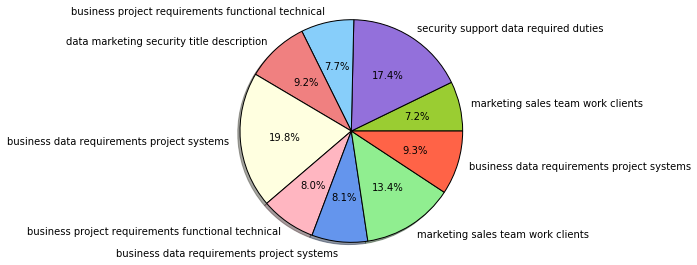



Analysis for Senior Management
Principal Components
component_0: accounting care financial audit department
component_1: sales care living community residents
component_2: media marketing care living community
component_3: accounting media marketing financial audit
component_4: marketing accounting financial media care
component_5: client project accounting care living
component_6: project program mit sales manager


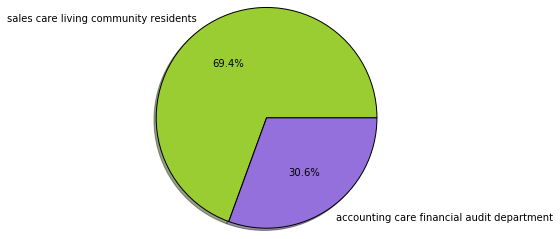



Analysis for Sports/Fitness
Principal Components
component_0: sales fitness marketing work skills
component_1: fitness personal training trainer members
component_2: sales fitness personal training members
component_3: summary sales job position retail
component_4: summary personal fitbit data fitness
component_5: summary members fitbit member staff
component_6: media summary marketing social personal


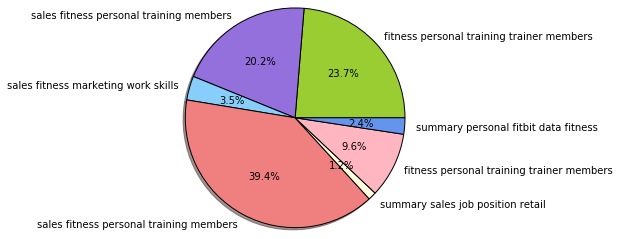



Analysis for Skilled Trade
Principal Components
component_0: handyman craftsman remodeler home contractor
component_1: sales handyman customer business remodeler
component_2: sales customer craftsman maintenance work
component_3: rio grande valley craftsman professional
component_4: lush retail rio grande store
component_5: lush store retail shop recruiting
component_6: contractor remodeler design handyman craftsman


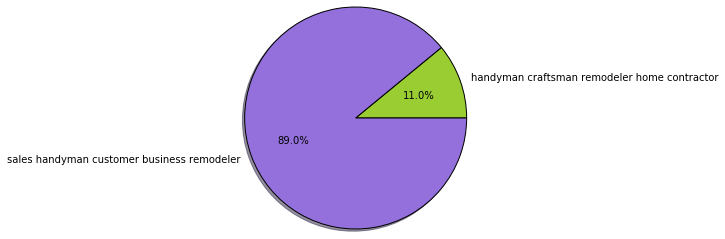

In [3]:
%matplotlib inline
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

# test_set = ["Accounting/Finance","Business Development/Consulting","Legal","Marketing/Advertising/PR","Medical/Healthcare",
#            "Science/Research","Travel/Transportation","Manufacturing/Production/Construction","Beauty/Wellness"]
def kmeans(X, k):
    '''
    MAX = 20
    error = np.zeros(MAX)
    sc = np.zeros(MAX)
    for k in range(2,MAX):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
        sc[k] = metrics.silhouette_score(X,kmeans.labels_,metric='euclidean')
    plt.title('K-means Clustering')
    plt.plot(range(2,MAX),error[2:])
    plt.xlabel('Number of Clusters')
    plt.ylabel('Error')
    plt.show()
    plt.title('K-means Clustering')
    plt.plot(range(2,MAX),sc[2:])
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Coefficient')
    plt.show()
    '''
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100)
    kmeans.fit_predict(X)
    return kmeans.labels_

def analyze(cluster_data, pc_num, k, cluster_text_dictionary):
    labels = kmeans(cluster_data.ix[:,4:].values, k)
    cluster_data['label'] = labels
    distributions = [] # the percent distribution of each cluster
    text_labels = [] # the text label of each cluster
    for c in range(0, k):
        df = cluster_data[cluster_data.label == c] # all the jobs in cluster c
        if len(df) == 0: 
            distributions.append(0)
            text_labels.append('')
        else:
            distributions.append(len(df)/len(cluster_data))
            component_count = [] # count of the times where a component contributed the highest weight
            for i in range(0, pc_num):
                component_count.append(0)
            for idx, row in df.iterrows(): # iterate over all the jobs in cluster c
                component_weights = [abs(x) for x in row[4:-1].tolist()]
                component_count[component_weights.index(max(component_weights))] += 1
            top_count = max(component_count)
            x = component_count.index(top_count)
            if x == 0:
                component_count.remove(top_count)
                second_top_count = max(component_count)
                if (top_count-second_top_count)/len(df) < 0.1:
                    x = component_count.index(second_top_count)+1
            text_labels.append(' '.join(cluster_text_dictionary[x]))
    colors = [COLOR[i%len(COLOR)] for i in range(0, k)]
    plt.pie(distributions, labels=text_labels, colors=colors, autopct='%1.1f%%', shadow=True)
    plt.axis('equal')
    plt.show()

for category in test_set:
    print("========================================")
    print("Analysis for " + category)
    print("========================================")
    # retrieve information from dictionaries
    (df, u, s, vt) = data_set[category]
    pc_num = pc_num_dictionary[category]
    k = k_value_dictionary[category]
    
    # print the top x terms in each principal component
    print("Principal Components")
    x = 5
    TERMS = vt.columns.values
    cluster_text_dictionary = {}
    for i in range(0, pc_num):
        componenti = vt.iloc[i].tolist()
        top = np.argsort(componenti)
        topterms = []
        for j in range(0, x):
            topterms.append(TERMS[top[j]])
        cluster_text_dictionary[i] = topterms
        print("component_" + str(i) + ": " + ' '.join(topterms))
    print("========================================")
    
    # prepare data for clustering
    Xk = u[:,:pc_num] @ np.diag(s[:pc_num])
    columns = []
    for i in range(0, pc_num):
        columns.append('component_' + str(i))
    Xk_df = DataFrame(Xk, index = df.index, columns = columns)
    cluster_data = pd.concat([df, Xk_df], axis=1, join='inner')
    analyze(cluster_data, pc_num, k, cluster_text_dictionary)
    print("\n")
